In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:

filenames = os.listdir(r"C:\Users\nguyent2\Desktop\Training_1")
categories = []
for filename in filenames:
    category = filename[0]
    if category == "3":
        categories.append("triangle")
    elif category == "4":
        categories.append("square")
    elif category == "5":
        categories.append("pentagon")
    elif category == "6":
        categories.append("hexagon")
    elif category == "7":
        categories.append("heptagon")
    elif category == "8":
        categories.append("octagon")
    elif category == "9":
        categories.append("nonagon")
    else:
        categories.append("decagon")

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


#This line used to shuffle the dataset
df = df.sample(frac=1)

In [4]:
df.to_csv(r"C:\Users\nguyent2\Desktop\New.csv")
df.head()

,filename,category
6771,8_sides_793.png,octagon
1415,3_sides_472.png,triangle
1468,3_sides_52.png,triangle
616,10_sides_653.png,decagon
1703,3_sides_731.png,triangle


In [5]:
df.tail()

,filename,category
7626,9_sides_662.png,nonagon
4378,6_sides_439.png,hexagon
2444,4_sides_499.png,square
3595,5_sides_634.png,pentagon
3571,5_sides_612.png,pentagon


<AxesSubplot:>

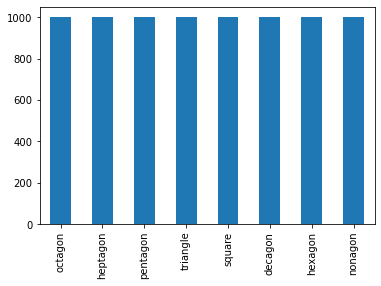

In [6]:
df['category'].value_counts().plot.bar()

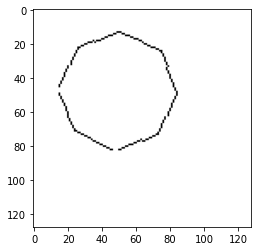

In [7]:
sample = random.choice(filenames)
image = load_img(r"C:\Users\nguyent2\Desktop\Training_1\\" + sample)
plt.imshow(image)

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(2, (5, 5), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(4, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(8, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 2)       152       
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 2)       8         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 2)         0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 4)         204       
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 58, 4)         16        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 4)         0

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
earlystop = EarlyStopping(patience=10)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

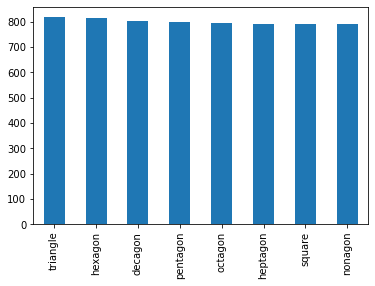

In [16]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

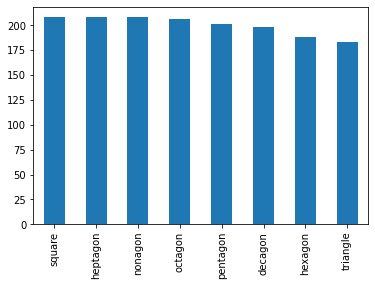

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, r"C:\Users\nguyent2\Desktop\Training_1", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size= batch_size
)


Found 6400 validated image filenames belonging to 8 classes.


In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"C:\Users\nguyent2\Desktop\Training_1", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1600 validated image filenames belonging to 8 classes.


In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,   r"C:\Users\nguyent2\Desktop\Training_1", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [22]:
plt.figure(figsize=(128, 128))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [23]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
426/426 [==============================] - 55s 128ms/step - loss: 2.5381 - accuracy: 0.1408 - val_loss: 2.0491 - val_accuracy: 0.1516
Epoch 2/50
426/426 [==============================] - 49s 114ms/step - loss: 2.2125 - accuracy: 0.1540 - val_loss: 2.0126 - val_accuracy: 0.2208
Epoch 3/50
426/426 [==============================] - 49s 115ms/step - loss: 2.0662 - accuracy: 0.1898 - val_loss: 2.1955 - val_accuracy: 0.1849
Epoch 4/50
426/426 [==============================] - ETA: 0s - loss: 1.9851 - accuracy: 0.2218
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
426/426 [==============================] - 48s 114ms/step - loss: 1.9851 - accuracy: 0.2218 - val_loss: 3.7364 - val_accuracy: 0.1296
Epoch 5/50
426/426 [==============================] - 49s 114ms/step - loss: 1.9160 - accuracy: 0.2454 - val_loss: 6.4091 - val_accuracy: 0.1270
Epoch 6/50
426/426 [==============

In [24]:
model.save_weights("model.h5")

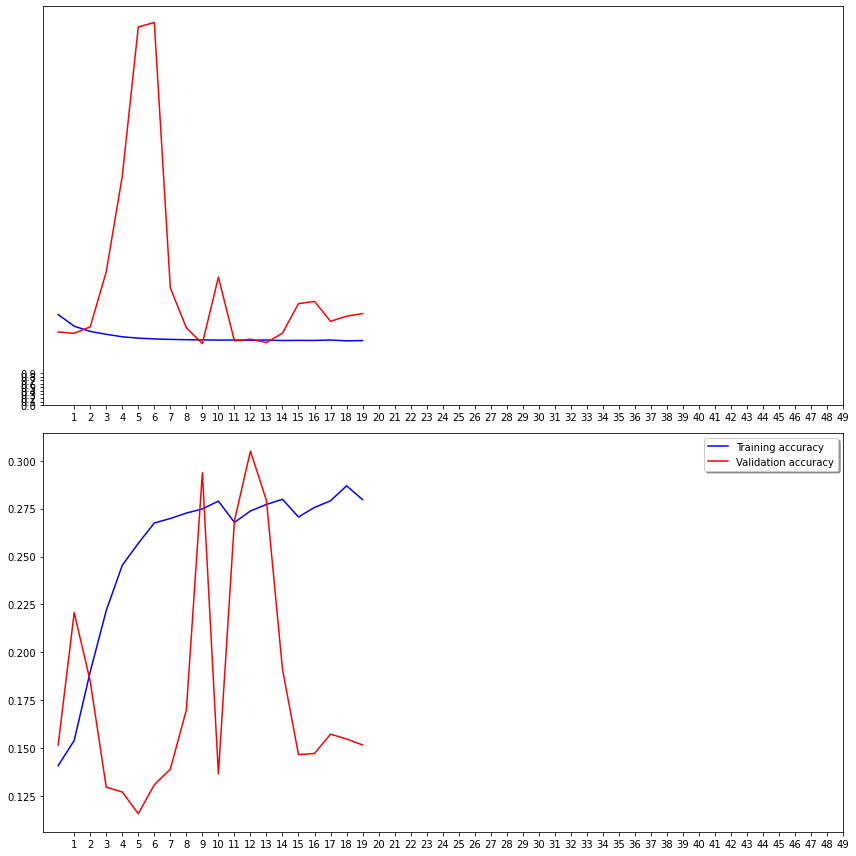

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [37]:
test_filenames = os.listdir(r"C:\Users\nguyent2\Desktop\Training")

test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [38]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"C:\Users\nguyent2\Desktop\Training", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 80000 validated image filenames.


In [39]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [40]:
test_df['category'] = np.argmax(predict, axis=-1)

In [41]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

<AxesSubplot:>

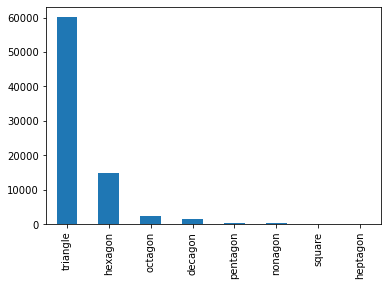

In [45]:
test_df['category'].value_counts().plot.bar()

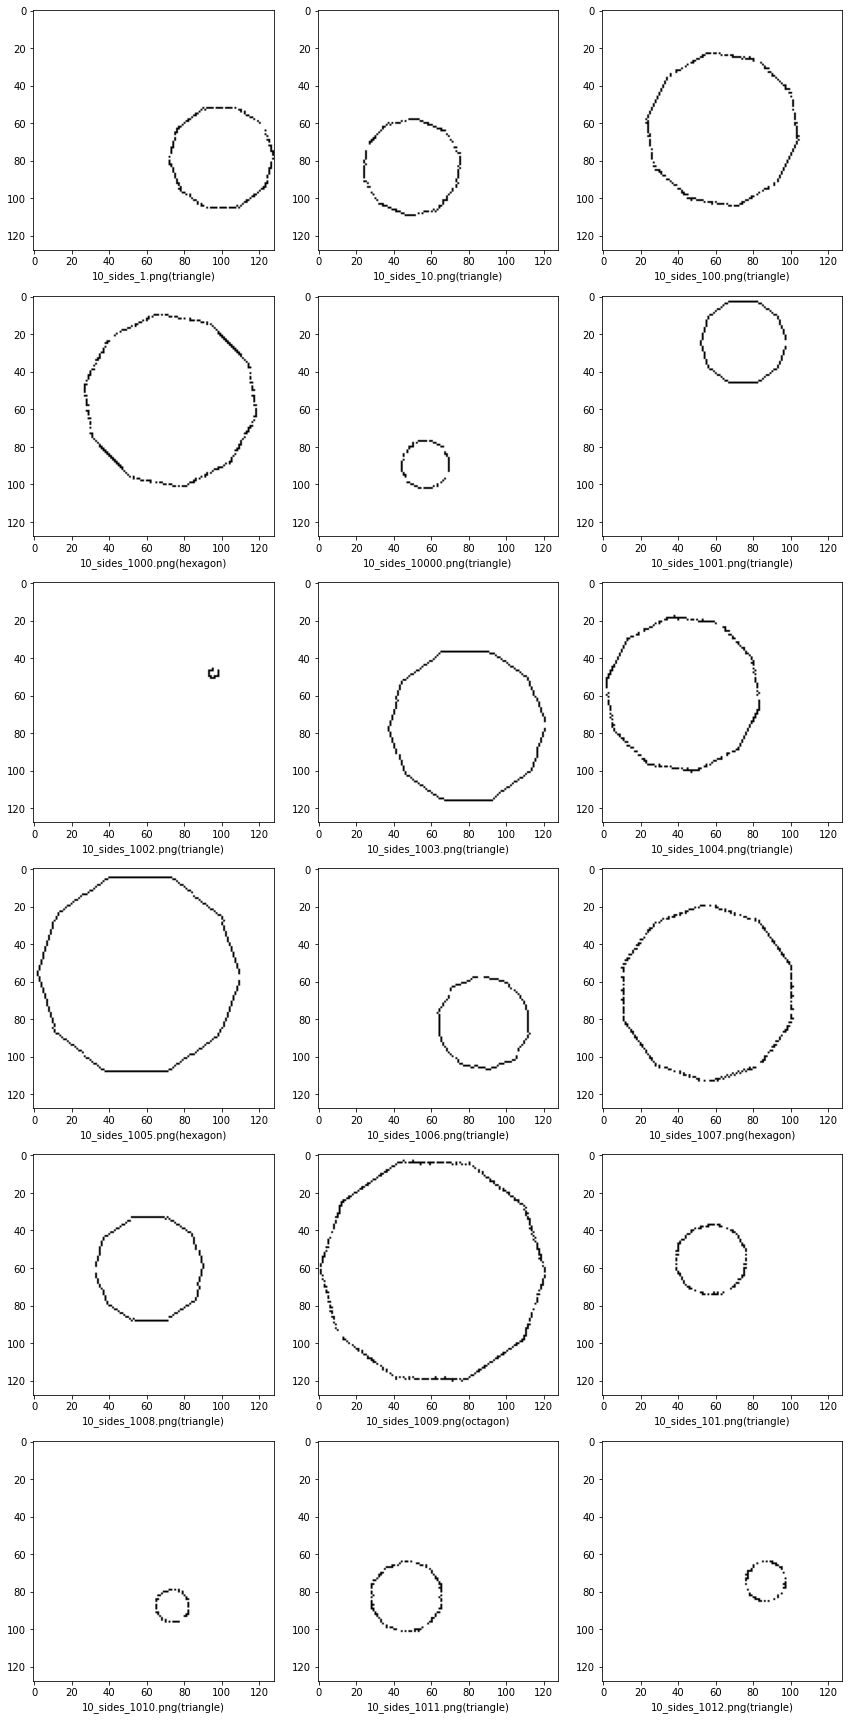

In [46]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r"C:\Users\nguyent2\Desktop\Training\\"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()